In [1]:
import pandas as pd
import numpy as np
import os
import teetool as tt
from collections import OrderedDict

/home/will/anaconda3/envs/tt/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# SETTINGS
M = -1 # resampling (reduces points, doesn't interpolate), negative turns off
store_this_case_x = "t2 [-]" # choose dimension!

In [3]:
# read data

df = pd.read_csv("data/rocket_trajectories.csv")

# rename columns
df.rename(columns={'TIME_SECONDS_DOUBLE': 't [s]', 
                   'EASTINGS_METERS_DOUBLE': 'x [m]',
                   'NORTHINGS_METERS_DOUBLE': 'y [m]',
                   'ALTITUDE_METERS_DOUBLE': 'z [m]',
                   'DISTANCE_METERS_DOUBLE': 'd [m]'}, inplace=True)


# "is_event column
temp = np.diff(df["EVENT_INT"])
temp = np.concatenate(([0],temp))
df["is_event"] = (temp == 1)

df_us = df # copy

# normalise x y z GLOBALLY (all trajectories)
these_cells_input = ["x [m]", "y [m]", "z [m]"]
these_cells_output = ["x [-]", "y [-]", "z [-]"]

for (i, cell_input) in enumerate(these_cells_input):
    cell_output = these_cells_output[i]
    df_us.loc[:,cell_output] = (df_us[cell_input] - df_us[cell_input].min()) / ( df_us[cell_input].max() - df_us[cell_input].min() )

# normalise time / distance LOCALLY (per trajectory)
these_cells_input = ["t [s]", "d [m]"]
these_cells_output = ["t [-]", "d [-]"]

for (i, cell_input) in enumerate(these_cells_input):
    cell_output = these_cells_output[i]
    df_col = df_us[cell_input]
    temp = [];
    for i1 in df_us.ID_STR.unique():
        # this trajectory
        df1 = df_col[(df_us["ID_STR"] == i1)]
        temp1 = ( df1 - df1.min() ) / ( df1.max() - df1.min() )
        # concatenate
        temp = np.concatenate((temp, temp1.values), axis=0)
    # store altered dimension
    df_us[cell_output] = temp

# find partitions
df_part = pd.DataFrame(columns = ["EVENT_INT","ID_STAGE_STR","DIM","MIN","MAX"])

these_dim = ["t [-]", "d [-]"]

# use mean trajectory as guide
df1 = df_us[df_us["ID_STR"] == 0]

last_max_dic = {}

for this_dim in these_dim:
    last_max_dic[this_dim] = 0


for this_stage in df_us["ID_STAGE_STR"].unique():
    # this stage

    for this_event in df_us["EVENT_INT"].unique():
        # this event

        # consider only this segment of events
        df2 = df_us[df_us["EVENT_INT"] == this_event]

        for this_dim in these_dim:
            # this dimension

            # extract this dimension
            df3 = df2[this_dim]

            # extract minimum range of this segment
            event_min = last_max_dic[this_dim]

            # extract maximum range of this segment
            event_max = df3.max()

            # update last max
            last_max_dic[this_dim] = event_max

            # calculate different
            #event_diff = event_max - event_min

            # new addition
            df_temp = pd.DataFrame({"EVENT_INT":[this_event],
                                    "DIM":[this_dim],"MIN":[event_min],
                                    "MAX":[event_max],
                                   "ID_STAGE_STR":[this_stage]})

            # append addition
            df_part = df_part.append(df_temp,ignore_index=True)

# normalise time / distance SUPER LOCALLY (per trajectory, per segment)
these_cells_input = ["t [-]", "d [-]"]
these_cells_output = ["t2 [-]", "d2 [-]"]

for (i, this_dim) in enumerate(these_cells_input):

    # input / output combination
    cell_output = these_cells_output[i]

    # consider this dimension
    #this_dim = df_us[cell_input]

    for this_traj in df_us.ID_STR.unique():
        # this trajectory
        #df2 = df1[(df_us["ID_STR"] == this_traj)]

        for this_event in df_us.EVENT_INT.unique():
            # single segment/event
            these_rows = ((df_us["ID_STR"] == this_traj) &
                            (df_us["EVENT_INT"] == this_event))

            # extract data
            temp_data = df_us.loc[these_rows, this_dim]

            # normalised array (one trajectory, one segment)
            temp_norm = ( temp_data - temp_data.min() ) / ( temp_data.max() - temp_data.min() )

            # extract information 
            these_rows2 = ((df_part["DIM"] == this_dim) &
                               (df_part["EVENT_INT"] == this_event))

            event_min = df_part.loc[these_rows2, "MIN"].values
            event_max = df_part.loc[these_rows2, "MAX"].values

            # modify to fit stretch
            temp_fit = (event_max - event_min) * temp_norm + event_min

            # store new data in cell_output
            df_us.loc[these_rows, cell_output] = temp_fit

# **************************************************
# put data into arrays
# *************************

# number of trajectories
N = df_us.ID_STR.unique().size

cluster_data = []

for (n, id_str) in enumerate(df_us.ID_STR.unique()):

    df1 = df_us[df_us["ID_STR"] == id_str]

    # remove duplicate entries
    df1 = df1.drop_duplicates(subset=('x [m]', 'y [m]', 'z [m]'))

    Yn = np.array([df1["x [m]"].values, df1["y [m]"].values, df1["z [m]"].values]).transpose()
    # 
    xn = np.array(df1[store_this_case_x].values)

    # filter finite values
    mask = np.isfinite(xn)
    Yn = Yn[mask, :]
    xn = xn[mask]

    # add tuple to list
    cluster_data.append((xn, Yn))

In [4]:
# cluster_data ready

# new world -- nres defines default resolution of tube/logp grid generation
world = tt.World(name="", ndim=3)

# add data to the world
world.addCluster(cluster_data, "rocket")

world.buildModel(settings={"model_type":"resampling", "ngaus":100})


/home/will/anaconda3/envs/tt/lib/python2.7/site-packages/numpy/linalg/linalg.py:1457: RuntimeWarning: divide by zero encountered in true_divide
  return s[..., 0]/s[..., -1]


In [16]:
# visualise 3d

visual = tt.visual_3d.Visual_3d(world, size=(1200, 900))

# visualise trajectories
visual.plotTrajectories([0], ntraj=50, colour=(0.0, 0.0, 0.0))
# visualise tube
visual.plotTube([0], alpha=0.5, resolution=20, colour=(0.3, 1.0, 0.3))
visual.plotTrajectoriesPoints(x1=0.15, ntraj=50, colour=(1.0, 0.0, 0.0), scale_factor=50)

# 1000m = 1km = 1 km^3 is one grid block
visual.plotGrid(resolution=500,
                outline=[-1000, 1000, 0, 3000, 0, 3000])
# labels and ticks
visual.setLabels("Easting [m]", "Northing [m]", "Altitude [m]")
visual.setAxesFormat("%.0f")  # no ticks

visual.show() # use visual.show() to pause figures at end and not auto-close

In [ ]:
world.getTubeStats(sdwidth=1, resolution=100)

/home/will/anaconda3/envs/tt/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


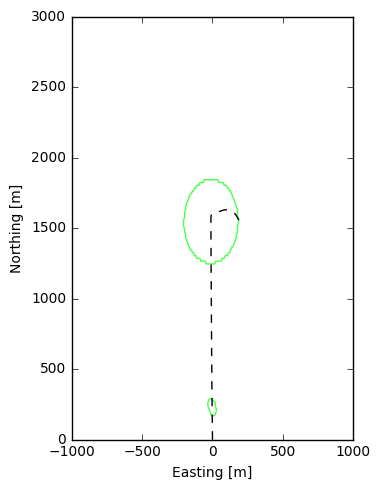

In [17]:
% matplotlib inline

visual = tt.visual_2d.Visual_2d(world, figsize=(5, 5), dpi=600, tight_layout=True)
visual.plotTube(list_icluster=[0], z=1000, resolution=[100, 100], colour=(0.3, 1.0, 0.3))
# plot mean
visual.plotMean(list_icluster=[0], colour=(0.0, 0.0, 0.0), linestyle='--')
# set labels
visual._ax.set_xlabel("Easting [m]")
visual._ax.set_ylabel("Northing [m]")
visual._ax.set_xlim([-1000, 1000])
visual._ax.set_ylim([0, 3000])
visual._ax.set_title("")
# equal scale
visual._ax.set_aspect('equal', adjustable='box')
# store image
#visual.save(add=save_as)
# close figure
#visual.close()
visual.show()